# Práctico 2: Recomendación de videojuegos

En este práctico trabajaremos con un subconjunto de datos sobre [videojuegos de Steam](http://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). Para facilitar un poco el práctico, se les dará el conjunto de datos previamente procesado. En este mismo notebook mostraremos el proceso de limpieza, para que quede registro del proceso (de todas maneras, por el tamaño de los datos no recomendamos que pierdan tiempo en el proceso salvo que lo consideren útil a fines personales). 

El conjunto de datos se basa en dos partes: lista de juegos (items), y lista de reviews de usuarios sobre distintos juegos. Este último, en su versión original es muy grande, (pesa 1.3GB), por lo que será solo una muestra del mismo sobre la que trabajarán.

A diferencia del conjunto de datos de LastFM utilizados en el [Práctico 1](./practico1.ipynb), en este caso los datos no están particularmente pensados para un sistema de recomendación, por lo que requerirá de un poco más de trabajo general sobre el dataset.

La idea es que, de manera similar al práctico anterior, realicen un sistema de recomendación. A diferencia del práctico anterior, este será un poco más completo y deberán hacer dos sistemas, uno que, dado un nombre de usuario le recomiende una lista de juegos, y otro que dado el título de un juego, recomiende una lista de juegos similares. Además, en este caso se requiere que el segundo sistema (el que recomienda juegos basado en el nombre de un juego en particular) haga uso de la información de contenido (i.e. o bien harán un filtrado basado en contenido o algo híbrido).

## Obtención y limpieza del conjunto de datos

El conjunto de datos originalmente se encuentra en archivos que deberían ser de formato "JSON". Sin embargo, en realidad es un archivo donde cada línea es un objeto de JSON. Hay un problema no obstante y es que las líneas están mal formateadas, dado que no respetan el estándar JSON de utilizar comillas dobles (**"**) y en su lugar utilizan comillas simples (**'**). Afortunadamente, se pueden evaluar como diccionarios de Python, lo cuál permite trabajarlos directamente.

### Descarga

La siguiente celda descarga los conjuntos de datos crudos. Nuevamente, no es necesario ejecutarla y pueden ir [más abajo](#Conjunto-de-datos-limpio) para ejecutar la celda que descargará el conjunto ya procesado.

In [ ]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/steam_games.json.gz http://cseweb.ucsd.edu/\~wckang/steam_games.json.gz
curl -L -o data/steam/steam_reviews.json.gz http://cseweb.ucsd.edu/\~wckang/steam_reviews.json.gz

### Carga de datos

Como se dijo, por la naturaleza de los datos, necesitamos utilizar Python para trabajarlos (no podemos leerlos con JSON).

In [26]:
import gzip
from tqdm import tqdm_notebook  # To print a progress bar (comes with Anaconda or can be installed)

with gzip.open("./data/steam/steam_games.json.gz") as fh:
    games = []
    for game in tqdm_notebook(fh, total=32135):
        try:
            games.append(eval(game))
        except SyntaxError:
            continue

print("Loaded {} games".format(len(games)))

with gzip.open("./data/steam/steam_reviews.json.gz") as fh:
    reviews = []
    for review in tqdm_notebook(fh, total=7793069):
        try:
            reviews.append(eval(review))
        except SyntaxError:
            continue

print("Loaded {} user reviews".format(len(reviews)))


Loaded 32135 games



Loaded 7793069 user reviews


### Exploración de los datos

En esta parte necesitamos revisar la estructura general, para poder pasarlos a un formato más amigable (e.g. CSV).

In [27]:
games[0]

{'publisher': 'Kotoshiro',
 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'],
 'app_name': 'Lost Summoner Kitty',
 'title': 'Lost Summoner Kitty',
 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/',
 'release_date': '2018-01-04',
 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'],
 'discount_price': 4.49,
 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player'],
 'price': 4.99,
 'early_access': False,
 'id': '761140',
 'developer': 'Kotoshiro'}

In [28]:
reviews[0]

{'username': 'Chaos Syren',
 'product_id': '725280',
 'page_order': 0,
 'text': 'This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain.',
 'hours': 0.1,
 'recommended': True,
 'products': 41,
 'date': '2017-12-17',
 'early_access': False,
 'page': 1}

### Transformación de los datos

Viendo los datos que tenemos de cada tipo, podemos utilizar pandas para leer los registros y trabajar con algo más sencillo.

In [29]:
import pandas as pd

In [30]:
games = pd.DataFrame.from_records(games)
games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [31]:
reviews = pd.DataFrame.from_records(reviews)
reviews.head(3)

,username,product_id,page_order,text,hours,recommended,products,date,early_access,page,compensation,found_funny,user_id
0,Chaos Syren,725280,0,This would not be acceptable as an entertainme...,0.1,True,41.0,2017-12-17,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,0,looks like a facebook game,51.1,True,769.0,2017-12-27,False,1,NaN,NaN,NaN
2,hello?<,328100,1,Better than Minecraft,14.6,True,2.0,2017-10-16,False,1,Product received for free,2.0,NaN


### Selección de características

Teniendo los datos, podemos hacer una selección muy superficial (no basada en EDA) de algunas características que consideremos irrelevantes. En particular, para el caso del dataset de juegos, vemos que las columnas `url` y `reviews_url` no son útiles a los propósitos de este práctico, por lo que las removeremos.

Por el lado del dataset de opiniones todas parecen útiles. Aunque, si vemos muy por arriba `recommended` vemos que para todos los valores son `True`, por lo que la podemos sacar también.

In [32]:
games.drop(columns=["url", "reviews_url"], inplace=True)
games.head(3)

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [33]:
reviews.drop(columns=["recommended"], inplace=True)
reviews.head(3)

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,Chaos Syren,725280,0,This would not be acceptable as an entertainme...,0.1,41.0,2017-12-17,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,0,looks like a facebook game,51.1,769.0,2017-12-27,False,1,NaN,NaN,NaN
2,hello?<,328100,1,Better than Minecraft,14.6,2.0,2017-10-16,False,1,Product received for free,2.0,NaN


### Muestreo y guarda de datos

Como dijimos, tenemos muchas reviews. Sería excelente trabajarlas a todas, pero el dataset es medio pesado (en RAM llega a ocupar más de 8 GB). Por lo que optaremos por hacer un muestreo de reviews. Esto quiere decir que, probablemente, algunos usuarios/juegos queden afuera. Podríamos hacer algún muestreo estratificado, pero iremos por algo más sencillo. Dejaremos aproximadamente el 10% del dataset (700 mil reviews).

El conjunto de datos de juegos lo dejaremos como está. Lo guardaremos con formato JSON para conservar la información de aquellas columnas que sean de tipo lista.

In [1]:
games.to_json("./data/steam/games.json.gz", orient="records")
reviews.sample(n=int(7e5), random_state=42).to_json("./data/steam/reviews.json.gz", orient="records")

NameError: name 'games' is not defined

## Conjunto de datos limpio

Para descargar el conjunto de datos que se utilizará en el práctico, basta con ejecutar la siguiente celda.

In [ ]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/games.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/games.json.gz
curl -L -o data/steam/reviews.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/reviews.json.gz

## Ejercicio 1: Análisis Exploratorio de Datos

Ya teniendo los datos, podemos cargarlos y empezar con el práctico. Antes que nada vamos a hacer una exploración de los datos. Lo principal a tener en cuenta para este caso es que debemos identificar las variables con las que vamos a trabajar. A diferencia del práctico anterior, este conjunto de datos no está documentado, por lo que la exploración es necesaria para poder entender que cosas van a definir nuestro sistema de recomendación.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

### Características del conjunto de datos sobre videojuegos

Las características del conjunto de datos de videojuegos tienen la información necesaria para hacer el "vector de contenido" utilizado en el segundo sistema de recomendación. Su tarea es hacer un análisis sobre dicho conjunto de datos y descartar aquella información redundante.

In [97]:
games = pd.read_json("./data/steam/games.json.gz")
games.head()

,app_name,developer,discount_price,early_access,genres,id,metascore,price,publisher,release_date,sentiment,specs,tags,title
0,Lost Summoner Kitty,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140.0,None,4.99,Kotoshiro,2018-01-04,None,[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",Lost Summoner Kitty
1,Ironbound,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980.0,None,Free To Play,"Making Fun, Inc.",2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Ironbound
2,Real Pool 3D - Poolians,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290.0,None,Free to Play,Poolians.com,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Real Pool 3D - Poolians
3,弹炸人2222,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400.0,None,0.99,彼岸领域,2017-12-07,None,[Single-player],"[Action, Adventure, Casual]",弹炸人2222
4,Log Challenge,None,1.79,False,None,773570.0,None,2.99,None,None,None,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",None


In [98]:
# Completar
# Veamos los features que son redundantes, app_name y title tienen la misma info, por lo que eliminamos alguna
#idem con genres y tags, eliminamos tags
#idem con developer y publisher, eliminemos publisher
games.drop(columns=["app_name","tags","publisher"], inplace=True)
games.head()

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
0,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140.0,None,4.99,2018-01-04,None,[Single-player],Lost Summoner Kitty
1,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980.0,None,Free To Play,2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Ironbound
2,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290.0,None,Free to Play,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Real Pool 3D - Poolians
3,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400.0,None,0.99,2017-12-07,None,[Single-player],弹炸人2222
4,None,1.79,False,None,773570.0,None,2.99,None,None,"[Single-player, Full controller support, HTC V...",None


In [99]:
games.count()

developer         28836
discount_price      225
early_access      32135
genres            28852
id                32133
metascore          2677
price             30758
release_date      30068
sentiment         24953
specs             31465
title             30085
dtype: int64

### Características del conjunto de datos de reviews

Este será el conjunto de datos a utilizar para obtener información sobre los usuarios y su interacción con videojuegos. Como se puede observar no hay un rating explícito, sino uno implícito a calcular, que será parte de su trabajo (deberán descubrir que característica les puede dar información que puede ser equivalente a un rating).

In [100]:
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews.head()

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
0,None,2015-02-25,True,NaN,23.0,3159,0,227940,92.0,Just one word... Balance!,NaN,SPejsMan
1,None,2014-08-26,False,NaN,4.9,231,4,270170,217.0,Graphics: none\nMusic: Makes me want to sleep\...,7.656120e+16,Spodermen
2,None,2015-12-25,False,NaN,53.2,191,1,41700,78.0,"cheeki breeki iv danke, stalker",NaN,josh
3,None,2015-06-04,True,NaN,16.2,570,9,332310,178.0,I am really underwhelmed by the small about of...,NaN,Sammyrism
4,None,2015-10-02,False,NaN,1.8,967,9,303210,13.0,"I came into the game expecting nothing, of cou...",NaN,moonmirroir


In [101]:
reviews[reviews['product_id']==6060]

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
189,None,2013-12-27,False,NaN,5.2,2044,1,6060,309.0,one of the best first person shooters in history,NaN,potato chips
1035,None,2017-05-20,False,NaN,1.3,657,2,6060,96.0,good,NaN,Meow22
1053,None,2017-11-24,False,1.0,25.7,231,0,6060,284.0,"Star Wars Battlefront 2 is a pretty good game,...",7.656120e+16,Gunbuddy
1614,None,2016-08-19,False,NaN,78.3,966,8,6060,43.0,-Star Wars Battlefront 2-\nI'll make this shor...,NaN,Deadly Bounty Hunter
1753,None,2015-11-30,False,3.0,0.2,1325,3,6060,60.0,doesn't work or me.,7.656120e+16,KRAKATOA
2023,None,2015-12-14,False,NaN,0.7,1298,8,6060,279.0,"Firstly, I liked Battlefront a little more bu...",NaN,SgtSprinkles
2694,None,2016-10-30,False,NaN,19.4,932,3,6060,173.0,"While the game is great and all, you're best b...",NaN,Proxidius
2807,None,2016-02-14,False,NaN,37.9,1133,3,6060,16.0,my being downloading mod for is game and it ♥♥...,7.656120e+16,Calmcat12
2950,None,2015-12-02,False,NaN,19.5,1318,2,6060,290.0,I have played this game for about 80 hours (be...,NaN,Mono
2995,None,2014-05-10,False,NaN,34.7,1905,6,6060,16.0,This game was and still is my favorite video g...,7.656120e+16,KEK


In [102]:
games[games['id']==6060.0]# aca tenemos el problema del id que esta en flotante, por eso agregamos la funcion que lo convierte

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
272,Pandemic Studios,NaN,False,[Action],6060.0,78,9.99,2005-11-01,Very Positive,"[Single-player, Partial Controller Support, St...","Star Wars: Battlefront 2 (Classic, 2005)"


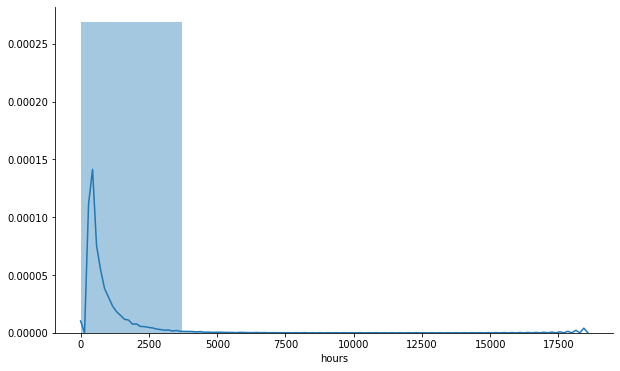

In [103]:
# Distribucion de los pesos con que se clasifican los juegos
plt.figure(figsize=(10,6))
seaborn.distplot(reviews['hours'].dropna(), bins=5)
seaborn.despine()

Creemos que es la columna hours indica si le gusto al usuario o no el juego.
Normalicemos las horas de juego

In [104]:
reviews['hours'].max()

18570.9

In [105]:
reviews['hours'].min()

0.0

## Ejercicio 2 - Sistema de Recomendación Basado en Usuarios

Este sistema de recomendación deberá entrenar un algoritmo y desarrollar una interfaz que, dado un usuario, le devuelva una lista con los juegos más recomendados.

In [ ]:
# Completar
#vemos que user_id no los tiene completos veamos como completarlos

In [106]:
reviews[['user_id','product_id','hours']].head()

,user_id,product_id,hours
0,NaN,227940,23.0
1,7.656120e+16,270170,4.9
2,NaN,41700,53.2
3,NaN,332310,16.2
4,NaN,303210,1.8


In [45]:
#reviews['username'].unique()

array(['SPejsMan', 'Spodermen', 'josh', ..., 'the troll slaiyer',
       'Gugaru', '🌸Ｃｕｎｔ Ｈａｔ🌸'], dtype=object)

In [46]:
#reviews['username'][:1000].head()

0       SPejsMan
1      Spodermen
2           josh
3      Sammyrism
4    moonmirroir
Name: username, dtype: object

Veamos los valores nulos en ambos data sets

In [107]:
review_null_count = reviews.isnull().sum()

In [108]:
review_null_count[review_null_count>0]

compensation    686714
found_funny     592625
hours             2442
products          1292
user_id         414413
dtype: int64

In [109]:
games_null_count = games.isnull().sum()

In [110]:
games_null_count[games_null_count>0]

developer          3299
discount_price    31910
genres             3283
id                    2
metascore         29458
price              1377
release_date       2067
sentiment          7182
specs               670
title              2050
dtype: int64

Como en las horas jugadas tenemos valores nulos, que los vamos a usar vamos a borrar los datos donde hours sean null.

In [111]:
reviews = reviews.dropna(subset=["hours"])

In [112]:
reviews.isnull().sum()

compensation    684286
date                 0
early_access         0
found_funny     590560
hours                0
page                 0
page_order           0
product_id           0
products          1290
text                 0
user_id         412703
username             0
dtype: int64

In [113]:
reviews.head()

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
0,None,2015-02-25,True,NaN,23.0,3159,0,227940,92.0,Just one word... Balance!,NaN,SPejsMan
1,None,2014-08-26,False,NaN,4.9,231,4,270170,217.0,Graphics: none\nMusic: Makes me want to sleep\...,7.656120e+16,Spodermen
2,None,2015-12-25,False,NaN,53.2,191,1,41700,78.0,"cheeki breeki iv danke, stalker",NaN,josh
3,None,2015-06-04,True,NaN,16.2,570,9,332310,178.0,I am really underwhelmed by the small about of...,NaN,Sammyrism
4,None,2015-10-02,False,NaN,1.8,967,9,303210,13.0,"I came into the game expecting nothing, of cou...",NaN,moonmirroir


In [114]:
reviews = reviews.reset_index(drop=True)

In [115]:
reviews.head()

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
0,None,2015-02-25,True,NaN,23.0,3159,0,227940,92.0,Just one word... Balance!,NaN,SPejsMan
1,None,2014-08-26,False,NaN,4.9,231,4,270170,217.0,Graphics: none\nMusic: Makes me want to sleep\...,7.656120e+16,Spodermen
2,None,2015-12-25,False,NaN,53.2,191,1,41700,78.0,"cheeki breeki iv danke, stalker",NaN,josh
3,None,2015-06-04,True,NaN,16.2,570,9,332310,178.0,I am really underwhelmed by the small about of...,NaN,Sammyrism
4,None,2015-10-02,False,NaN,1.8,967,9,303210,13.0,"I came into the game expecting nothing, of cou...",NaN,moonmirroir


In [117]:
# Creamos username_id a partir del nombre con id nuevo, ya que los ids estan mal, pero
# como vimos arriba al ser tantos nos quedamos con los 4000 primeros por problemas de memoria
username_ids = {}
for idu, names in enumerate(reviews['username'].unique()[:1000]):
#for idu, names in enumerate(reviews['username'].unique()):
    username_ids[idu] = reviews['username'].unique()[idu]
print(len(username_ids))    

1000


In [129]:
#username_ids

In [27]:
#username_ids.values()

In [118]:
#hacemos un dic para arreglar el user_id
username_id_column = []
for i in reviews['username'][:1000]:
    #print(i)
    if i in username_ids.values():
        username_new = list(username_ids.keys())[list(username_ids.values()).index(i)]
        username_id_column.append(username_new)
print(len(username_id_column))

1000


In [120]:
#corregimos user_id
df_reviews = reviews[:1000].fillna(0)
df_reviews['user_id'] = username_id_column # usamos el diccionario de arriba
df_reviews.to_csv("df_reviews.csv")

In [121]:
df_reviews[['user_id','product_id','hours']].head()

,user_id,product_id,hours
0,0,227940,23.0
1,1,270170,4.9
2,2,41700,53.2
3,3,332310,16.2
4,4,303210,1.8


Veamos si quedaron valores nulos:

In [122]:
df_reviews.isnull().sum()

compensation    0
date            0
early_access    0
found_funny     0
hours           0
page            0
page_order      0
product_id      0
products        0
text            0
user_id         0
username        0
dtype: int64

No quedaron valores nulos, porque fueron resueltos con el diccionario

In [123]:
games.isnull().sum()

developer          3299
discount_price    31910
early_access          0
genres             3283
id                    2
metascore         29458
price              1377
release_date       2067
sentiment          7182
specs               670
title              2050
dtype: int64

El titulo tiene valores None, esto lo tenemos que eliminar

In [124]:
# hagamos entero en id del juego
integer_id = []
for i in games['id']:
    string = str(i)
    #print(string)
    #print(string[:-2])
    if (string.find(".0")!=-1):
        integer_id.append(string[:-2])#porque le eliminamos el .0
    else:
        integer_id.append(string)
games['id'] = integer_id
games.head()

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
0,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140,None,4.99,2018-01-04,None,[Single-player],Lost Summoner Kitty
1,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980,None,Free To Play,2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Ironbound
2,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290,None,Free to Play,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Real Pool 3D - Poolians
3,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400,None,0.99,2017-12-07,None,[Single-player],弹炸人2222
4,None,1.79,False,None,773570,None,2.99,None,None,"[Single-player, Full controller support, HTC V...",None


In [125]:
games = games.dropna(subset=["title"])#eliminamos los juego que tienen null en el titulo

In [126]:
games.isnull().sum()#quedan algunos nulls, pero no los usamos

developer          1249
discount_price    29881
early_access          0
genres             1234
id                    0
metascore         27459
price              1260
release_date         18
sentiment          6926
specs               669
title                 0
dtype: int64

In [127]:
games = games.reset_index(drop=True)

In [128]:
games.head()

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
0,Kotoshiro,4.49,False,"[Action, Casual, Indie, Simulation, Strategy]",761140,None,4.99,2018-01-04,None,[Single-player],Lost Summoner Kitty
1,Secret Level SRL,NaN,False,"[Free to Play, Indie, RPG, Strategy]",643980,None,Free To Play,2018-01-04,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Ironbound
2,Poolians.com,NaN,False,"[Casual, Free to Play, Indie, Simulation, Sports]",670290,None,Free to Play,2017-07-24,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",Real Pool 3D - Poolians
3,彼岸领域,0.83,False,"[Action, Adventure, Casual]",767400,None,0.99,2017-12-07,None,[Single-player],弹炸人2222
4,Trickjump Games Ltd,NaN,False,"[Action, Adventure, Simulation]",772540,None,3.99,2018-01-04,Mixed,"[Single-player, Steam Achievements]",Battle Royale Trainer


In [130]:
# this makes an dictionary with the key database for all unique games
gamename_dict = {}
gamename_dictTwo = {}
for idx, names in enumerate(games['title']):
    #print(games['id'][idx])
    #print(idx)
    if games['id'][idx] not in gamename_dict:
        gamename_dict[games['id'][idx]] = games['title'][idx]
        gamename_dictTwo[games['title'][idx]] = games['id'][idx]# este diccionario es al reves del de arriba
    else:
        continue
#gamename_dict

In [155]:
games[games['id']=='6060']

,developer,discount_price,early_access,genres,id,metascore,price,release_date,sentiment,specs,title
261,Pandemic Studios,NaN,False,[Action],6060,78,9.99,2005-11-01,Very Positive,"[Single-player, Partial Controller Support, St...","Star Wars: Battlefront 2 (Classic, 2005)"


In [132]:
df_reviews[df_reviews['product_id']==6060]

,compensation,date,early_access,found_funny,hours,page,page_order,product_id,products,text,user_id,username
189,0,2013-12-27,False,0.0,5.2,2044,1,6060,309.0,one of the best first person shooters in history,189,potato chips


In [ ]:
Modelos

In [133]:
from surprise import Dataset, Reader, KNNWithMeans, KNNBasic, NormalPredictor, KNNWithZScore
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse

In [134]:
reader = Reader(rating_scale=(df_reviews.hours.min(), df_reviews.hours.max()))
videogames = Dataset.load_from_df(df_reviews[["user_id", "product_id", "hours"]], reader)

In [135]:
ratings_train, ratings_test = train_test_split(videogames, test_size=0.4)

In [136]:
model = KNNWithMeans(k=5).fit(ratings_train)
predictions = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 318.0881


In [137]:
#cross validation
reviews_games = pd.read_csv("df_reviews.csv")

In [138]:
model = KNNWithMeans(k=5, verbose=False)
cross_validated_metrics = cross_validate(model, videogames, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    341.1095216.1998378.2315374.6596285.1573319.071561.3325 
MAE (testset)     138.7596120.8816156.4357133.2600133.6417136.595711.5334 
Fit time          0.04    0.05    0.03    0.04    0.04    0.04    0.01    
Test time         0.00    0.01    0.00    0.00    0.00    0.00    0.00    


In [139]:
from scipy.sparse import csr_matrix
import numpy

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        product_mapper: dict that maps user id's to product indices
        user_inv_mapper: dict that maps user indices to user id's
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
    """
    M = df['user_id'].nunique()
    N = df['product_id'].nunique()

    user_mapper = dict(zip(numpy.unique(df['user_id']), list(range(M))))
    product_mapper = dict(zip(numpy.unique(df["product_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), numpy.unique(df['user_id'])))
    product_inv_mapper = dict(zip(list(range(N)), numpy.unique(df["product_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [product_mapper[i] for i in df['product_id']]

    X = csr_matrix((df["hours"], (user_index, item_index)), shape=(M,N))
    
    return X, user_mapper, product_mapper, user_inv_mapper, product_inv_mapper

X, user_mapper, product_mapper, user_inv_mapper, product_inv_mapper = create_X(reviews_games)

In [140]:
#reviews_games['product_id']

In [160]:
def find_similar_games(games_id, X, games_mapper, games_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        artist_id: id of the artist of interest
        X: user-artist utility matrix
        k: number of similar artist to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar artist ID's
    """
    X = X.T
    games_ids = []
    
    #print(games_id)
    #print(games_mapper)
    games_ind = games_mapper[games_id]    
    games_vec = X[games_ind]
    #print(games_vec)
    if isinstance(games_vec, (numpy.ndarray)):
        games_vec = games_vec.reshape(1,-1)
    
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors = k + 1, algorithm = 'brute', metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(games_vec, return_distance = False)
    
    for i in range(0, k):
        n = neighbour.item(i)
        games_ids.append(games_inv_mapper[n])
        
    games_ids.pop(0)
    return games_ids

In [142]:
n_ratings_per_game = X.getnnz(axis=0)

print(f"Most rated game has {n_ratings_per_game.max()} ratings.")
print(f"Least rated game has {n_ratings_per_game.min()} ratings.")

Most rated game has 21 ratings.
Least rated game has 1 ratings.


## Ejercicio 3 - Sistema de Recomendación Basado en Juegos

Similar al caso anterior, con la diferencia de que este sistema espera como entrada el nombre de un juego y devuelve una lista de juegos similares. El sistema deberá estar programado en base a información de contenido de los juegos (i.e. filtrado basado en contenido o sistema híbrido).

In [156]:
titleTwo = 'Star Wars: Battlefront 2 (Classic, 2005)'
idx = gamename_dictTwo[titleTwo]
int(idx)

6060

In [157]:
product_mapper[6060]

26

In [164]:
# getid gamenames
def getid(gamename):
    for number, name in gamename_dict.items():
        if name == gamename:
            id_number = number
    return id_number
print(getid("Beach Rules"))

768880


In [168]:
# gettitle gamenames
def gettitle(id_number):
    for number, name in gamename_dict.items():
        if str(id_number) == number:
            gamename = name
    return gamename
print(gettitle(768880))

Beach Rules


In [173]:
from sklearn.neighbors import NearestNeighbors

titleTwo = 'Star Wars: Battlefront 2 (Classic, 2005)'
idx = gamename_dictTwo[titleTwo]

n_recommendations = 5

similar_games = find_similar_games(int(idx), X, product_mapper, product_inv_mapper, metric='cosine', k=10)

print('Recomendaciones para {} ({}):'.format(titleTwo, idx))
#print(similar_games)
for e in similar_games:
    print(gettitle(int(e)))

Recomendaciones para Star Wars: Battlefront 2 (Classic, 2005) (6060):
Last Inua
LEGO® Worlds
State of Decay: YOSE
Grandia® II Anniversary Edition
Shark Attack Deathmatch 2
Tales from the Borderlands
Game of Thrones - A Telltale Games Series
Everlasting Summer
Deadlock: Planetary Conquest
